In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
import scipy as sp

from keras.models import Model
from keras.applications.resnet import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image

from glob import glob

In [2]:
image_files = glob('C:\\Users\\RW565TZ\\Practice\\Images\\puppies.jpg')

In [3]:
# Add preprocessing layer to the front of VGG

resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=True)

In [4]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)       

In [5]:
# Make a model to get output before flatten
activation_layer = resnet.get_layer('conv5_block3_out')

In [6]:
# Create a model object
model = Model(inputs=resnet.input, outputs=activation_layer.output)

1/1 [==============================] - 1s 956ms/step
[('n02099712', 'Labrador_retriever', 0.60465574), ('n02099601', 'golden_retriever', 0.35550284), ('n12144580', 'corn', 0.02400206), ('n13133613', 'ear', 0.010903937), ('n03884397', 'panpipe', 0.0027545136)]


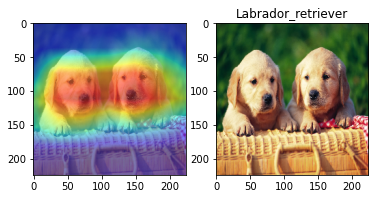

Continue? (Y/n)n


In [7]:
# get the feature map weights
final_dense = resnet.get_layer('predictions')
W = final_dense.get_weights()[0]


while True:
  img = tensorflow.keras.utils.load_img(np.random.choice(image_files), target_size=(224, 224))
  x = preprocess_input(np.expand_dims(img, 0))
  fmaps = model.predict(x)[0] # 7 x 7 x 2048

  # get predicted class
  probs = resnet.predict(x)
  classnames = decode_predictions(probs)[0]
  print(classnames)
  classname = classnames[0][1]
  pred = np.argmax(probs[0])

  # get the 2048 weights for the relevant class
  w = W[:, pred]

  # "dot" w with fmaps
  cam = fmaps.dot(w)

  # upsample to 224 x 224
  # 7 x 32 = 224
  cam = sp.ndimage.zoom(cam, (32, 32), order=1)

  plt.subplot(1,2,1)
  plt.imshow(img, alpha=0.8)
  plt.imshow(cam, cmap='jet', alpha=0.5)
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.title(classname)
  plt.show()

  ans = input("Continue? (Y/n)")
  if ans and ans[0].lower() == 'n':
    break